In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(ggrepel)
library(reshape2)
library(nleqslv)

## multiplot function from R cookbook
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths




## Simulation Event by Event

### Discrete event simulation program for a blocking system, i.e. a system with $m$ service units and no waiting room. The offered traffic $A$ is the product of the mean arrival rate and the mean service time.

The blocking system can be though as a queing system with $m$ server in parallel that reject the "customers" if there is not any available resource.

The modelling of the system is done through the following function:

In [3]:
%%R
hyperexp<-function(n,lambda1,lambda2,p1,p2){
  times<-rep(0,n)
  exp_matr<-matrix(c(rexp(n,lambda1),rexp(n,lambda2)),ncol = 2)
  temp<-replicate(n,sample(1:2,size = 1,prob = c(p1,p2)))
  for(i in 1:n){
    times[i]<-exp_matr[i,temp[i]]
  }
  return(times)
}

##########################################################################################
erlang_dist<-function(n,mean_erlang,nr_erlang){
  replicate(n,(-mean_erlang/nr_erlang)*log(prod(runif(nr_erlang))))
}

##########################################################################################
## Simulation
sim_ev_by_ev<-function(event_type="poisson", service="exp",n=10000,lambda=1,lambda2=1,
                       p1=0.5,p2=0.5,mean=8,par2=1,nr_erlang=10,nr_units=10,
                       return_val="complete",seed=NULL){
  set.seed(seed)
  if(event_type=="poisson"){
    event_list<-cumsum(rexp(n,lambda))
  }
  else if(event_type=="hyper"){
    event_list<-cumsum(hyperexp(n,lambda,lambda2,p1,p2))
  }
  else if(event_type=="erlang"){
    event_list<-cumsum(erlang_dist(n,mean_erlang = lambda,nr_erlang))
  }
  if(service=="exp"){
    t_service<-rexp(n,rate = 1/mean)
  }
  else if(service=="const"){
    t_service<-rep(x = mean,n)
  }
  else if(service=="norm"){
    t_service<-rnorm(n,mean = mean,sd = par2)
  }
  
  else if(service=="pareto"){
    u<-runif(n)
    t_service<-mean*(1-u)^(-1/par2)
  }
  
  t_free<-rep(0,nr_units)
  nr_served<-rep(0,nr_units)
  nr_rejected<-0
  
  for (i in 1:length(event_list)){
    nr_free<-sum(event_list[i]>t_free)
    
    if(nr_free>0){
      ind<-which(event_list[i]>t_free)[sample(1:length(which(event_list[i]>t_free)),1)]
      t_free[ind]<-event_list[i]+t_service[i]
      nr_served[ind]<- nr_served[ind]+1
    }
    
    else{
      nr_rejected<-nr_rejected+1
    }
  }
  
  if (return_val=="complete"){
    return(list("Rejected"=nr_rejected,"Served per units" =nr_served,
                "Total served"=sum(nr_served),
                "Fraction rejected"=nr_rejected/(sum(nr_served)+nr_rejected)))
  }
  
  else if(return_val=="simple"){
    return(nr_rejected/(sum(nr_served)+nr_rejected))
  }
}

The first 2 function simulates the _Exponential distribution_ and the _m-Erlang distribution_,that are generated respectively from an $U$ uniform distribution in (0,1) according to the following equations:

$$
\begin{aligned}
  X_{exponential}&=-\frac{1}{\lambda} \log U\\
  X_{Erlang}&=\frac{-\beta}{m} \ln \left(\prod_{i=1}^{m} U_{i}\right) \qquad \text{with mean }\beta
\end{aligned}
$$

Specifically, the function "hyperexp()" randomly sample an integer corresponding to the index of the _exponential distributions_ with given probability and return the generated pseudo-sequence.

The function "sim_ev_by_ev()" simulates the system and keep track of different variables:

- _nr_served_, is the number of served customers for each of the $m$ server.
- _nr_rejected_, is the number of rejected customers.
- _t_free_, is a vector that keep track of the time when the server are available.
- _t_service_, is a vector containing the values of the time needed for each customer.
- _event_list_, is the clock time, so a vector with consecutive arrival time.

The function can generate internally both _t_service_ and _event_list_ from different type of distributions; the customers are _randomly_ assigned to an available server(if available), or rejected. When a customer is served both _nr_served_ and _t_free_ are updated. Finally the function can return a list containg _nr_served_, _nr_rejected_ and their combination(as total number of served customer or fraction of rejected/blocked customer) or can simply return the fraction of blocked customer. A seed can be set to reproduce the result (but this can be detrimental for the random assignation of the customers).

It should be noted that _t_service_ and _event_list_ are pre-computed, this permit a single call of the function for all the request of the exercise, however there is a 1-on-1 corrispondence between customers ans service time: in other words if the $k^{th}$ costumer is rejected, then the $k^{th}$ service time is not computed, and if the $(k+1)^{th}$ customer is accepted, then the service time utilized will be the $(k+1)^{th}$; this can be easily changed putting "_t_service[i-nr_rejected]_" instead of "_t_service[i]_".

### The arrival process is modelled as a Poisson process. Report the fraction of blocked customers, and a confidence interval for this fraction. Choose the service time distribution as exponential. The parameters: $m=10,$ mean service time $=8$ time units, mean time between customers $=1$ time unit (corresponding to an offered traffic of $8 \text { erlang }$), $10 \times 10.000$ customers.

Before proceding in the simulation it is possible to estimate the fraction of blocked customers analytically using the _Erlangs B-formula_:

$$
B=P(m)=\frac{\frac{A^{m}}{m !}}{\sum_{i=0}^{m} \frac{A^{i}}{i !}}
$$

where $A$ is defined as $A=\lambda s$ with arrival intensity $\lambda$ and mean service time $s$.

This formula is only valid for an arrival process modelled as a Poisson process, without assumption on the distribution of the service time.

In [4]:
%%R
lambda<-1
s<-8
A<-lambda*s
m<-10
B_up<-((A^m)/factorial(m))
B_down<-rep(0,m)
for(i in 1:m){
  B_down[i]<-A^i/factorial(i)
}
B<-B_up/sum(B_down)
B

[1] 0.1217111


So the propability of being rejected is $\sim 0.1217$.

Lets now perform a simple run of the simulation with total number of arrival $n=10000$ and exponential distribution of the service time with mean $s=8$ and arrival intensity $\lambda=1$:

In [5]:
%%R
# The parameters are explicit here but are the same as the default ones
sim_ev_by_ev(event_type = "poisson",service = "exp",lambda = 1, mean = 8,
             nr_units = 10,seed = 1)

$Rejected
[1] 1294

$`Served per units`
 [1] 867 867 868 885 886 878 882 864 884 825

$`Total served`
[1] 8706

$`Fraction rejected`
[1] 0.1294



As possible to see from the output, the total number of blocked customer is 1294, so the fraction is 0.1294, really close to the analytical one, also as expected from a random assignation of the customers, the number of services performed for each unit is quite balanced with the exception of the $10^{th}$ one, that show a slighty "lighter" workload.

---

**N.B.**
When possible and to conduct an appropriate discussion and comparison, runs with seed setted will be performed.

This choice is suboptimal as the random generation "becomes" a mathematical function of the seed.

---

It is required to perform 10 runs of the simulation with 10000 customers each and also to compute a confidence interval that will be based on the following formulation:
$$
\mu-t_{\alpha/2} \frac{s}{\sqrt{n}}\leq \mu \leq\mu +t_{\alpha/2} \frac{s}{\sqrt{n}}
$$

So first implement a function that will return mean and confidence intervals of the mean:

In [6]:
%%R
mean_conf_int<-function(x,power=0.95){
  conf_int<-t.test(x,conf.level = power)$conf.int
  return(list("mean"=mean(x), "lower bound"=min(conf_int),"upper bound"=max(conf_int)))
}

To compute multiple run will be used the "replicate()" function, the computed confidence interval is 95%:

In [7]:
%%R
Part1<-replicate(10,sim_ev_by_ev(return_val = "simple"))
mean_conf_int(Part1)

$mean
[1] 0.11992

$`lower bound`
[1] 0.1164622

$`upper bound`
[1] 0.1233778



now with seed:

In [8]:
%%R
seeds <- 11:20
count <- 0
Part1<-replicate(10, { count <<- count + 1; sim_ev_by_ev(return_val = "simple",
                                                         seed = seeds[count])})
mean_conf_int(Part1)

$mean
[1] 0.12191

$`lower bound`
[1] 0.1185399

$`upper bound`
[1] 0.1252801



So this result of 0.12191 should be close to the result of the previous simulation with NULL seed, also the confidence interval for the mean is narrow, around 0.04, so this is a very good result considering only 10 runs.

### The arrival process is modelled as a renewal process with same parameters. Report the fraction of blocked customers, and a confidence interval

As said before, this part of the exercise will follow what already done in the previous part

### Experiment with Erlang distributed inter arrival times with mean of 1

Recalling the previous formulation of the Erlang distribution:
$$
X_{Erlang}=\frac{-\beta}{m} \ln \left(\prod_{i=1}^{m} U_{i}\right) \qquad \text{with mean }\beta
$$
$m$ will be set to 10:

In [9]:
%%R
seeds <- 21:30
count <- 0
Part_erlang<-replicate(10, { count <<- count + 1; sim_ev_by_ev(event_type = "erlang", 
                                                         lambda = 1, nr_erlang = 10,
                                                         return_val = "simple",
                                                         seed = seeds[count])})
mean_conf_int(Part_erlang)

$mean
[1] 0.06665

$`lower bound`
[1] 0.06402567

$`upper bound`
[1] 0.06927433



In this case the fraction of blocked customer is around half the one modelled as poisson process, and the confidence interval is really small, around 0.002

As this result is a bit surpring it is possible to test for the sample mean of the implemented erlang distribution:

In [10]:
%%R
mean(erlang_dist(n=10000,mean_erlang = 1,nr_erlang = 10))

[1] 0.9987803


And this result show that in the long run the implementation of the distribution should be exact.

Let's try to find a result close to the Poisson process, setting $m$ to 2:

In [11]:
%%R
seeds <- 21:30
count <- 0
Part_erlang<-replicate(10, { count <<- count + 1; sim_ev_by_ev(event_type = "erlang", 
                                                         lambda = 1, nr_erlang = 2,
                                                         return_val = "simple",
                                                         seed = seeds[count])})
mean_conf_int(Part_erlang)

$mean
[1] 0.09086

$`lower bound`
[1] 0.08733797

$`upper bound`
[1] 0.09438203



As possible to see this result is closer to the poisson process, in fact with $m=1$ the result is "identical", also the confidence interval is larger than before, around 0.06; So the value of $m$ is a important factor.

### Hyper exponential inter arrival times,

The parameters for the hyper exponential distribution should be $p_{1}=0.8, \lambda_{1}=0.8333, p_{2}=0.2, \lambda_{2}=5.0$

Let's proceed with the simulation:

In [12]:
%%R
seeds <- 31:40
count <- 0
Part_hyper<-replicate(10, { count <<- count + 1; sim_ev_by_ev(event_type = "hyper", 
                                                         lambda = 0.8333, lambda2 = 5.0,
                                                         p1 = 0.8, p2 = 0.2,
                                                         return_val = "simple",
                                                         seed = seeds[count])})
mean_conf_int(Part_hyper)

$mean
[1] 0.14197

$`lower bound`
[1] 0.1370109

$`upper bound`
[1] 0.1469291



The result is slighlty larger than the poisson process, in fact in the long run the mean of this hyperexponential function with given parameter should be:

In [13]:
%%R
(0.8/0.8333)+(0.2/5.0)

[1] 1.000038


So the afflux of customers is in average "equal" yo the poisson process and so it expected the result to be in a similar range;

The confidence interval is slightly larger than the simple poisson process.


### The arrival process is a Poisson process, experiment with different service time distributions with the same mean service time and $m$.

Again all the simulation will be performed in the same fashion as before.

#### Constant service time

As understandable this is not an appropriate distribution, but it can be a good _"benchmark"_ to test the different distribution proposed(for both service time and arrival time)

In [14]:
%%R
seeds <- 41:50
count <- 0
Part_const<-replicate(10, { count <<- count + 1; sim_ev_by_ev(service = "const",
                                                         return_val = "simple",
                                                         seed = seeds[count])})
mean_conf_int(Part_const)

$mean
[1] 0.12366

$`lower bound`
[1] 0.1211223

$`upper bound`
[1] 0.1261977



As expected this is result is similar to the theoretical one.


#### Pareto distributed service times with at least $k=1.05$ and $k=2.05$

In the function the Pareto distribution is implemented as follows:
$$
X=\beta\left(1-U\right)^{-\frac{1}{k}}
$$
with $\beta$ that is the "mean", in this case the mean service time. Recall also that the expected value of the mean depend on the value of $k$:
$$
E(X)=\frac{k}{k-1} \beta
$$
So $\beta$ should be choose appropriately to obtain $E(X)=s=8$. First plot the Pareto Distributed Random Variables:

In [15]:
%%R
set.seed(42)
k1<-1.05; k2<-2.05
beta1<-((k1-1)*s)/k1
beta2<-((k2-1)*s)/k2
U<-runif(10000)
X1 <- beta1*(1-U)^(-1/k1)
X2 <- beta2*(1-U)^(-1/k2)
df<-data.frame("values"=c(X1,X2),"factor"=c(rep(k1,length(X1)),rep(k2,length(X2))))

As stated before the sample mean is largely different for the 2 samples, with $k=2.05$ the result however is closer to the mean $s=8$, with $k=1.05$ there is a larger variability on the results of the mean.

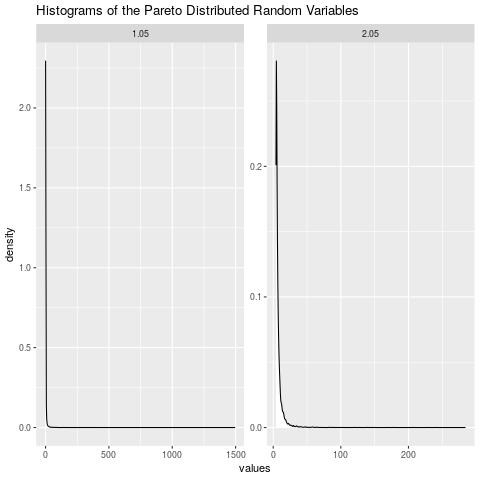

In [16]:
%%R
df%>%ggplot()+
  geom_density(aes(x=values),fill="white", color="black")+
  ggtitle("Histograms of the Pareto Distributed Random Variables")+
  facet_wrap(vars(factor), scales="free")

The plot dont give much information, but it is possible to see that the variability of the values decrease as $k$ increase.

Now simulate the system with $k=1.05$:

In [17]:
%%R
seeds <- 51:60
count <- 0
Part_pareto1<-replicate(10, { count <<- count + 1; sim_ev_by_ev(service = "pareto",
                                                              par2 = k1, mean=beta1,
                                                              return_val = "simple",
                                                              seed = seeds[count])})
mean_conf_int(Part_pareto1)

$mean
[1] 0.00126

$`lower bound`
[1] -6.85881e-05

$`upper bound`
[1] 0.002588588



Now the run with $k=2.05$ will be performed using the same seeds:

In [18]:
%%R
seeds <- 51:60
count <- 0
Part_pareto2<-replicate(10, { count <<- count + 1; sim_ev_by_ev(service = "pareto",
                                                              par2 = k2, mean=beta2,
                                                              return_val = "simple",
                                                              seed = seeds[count])})
mean_conf_int(Part_pareto2)

$mean
[1] 0.12005

$`lower bound`
[1] 0.1149912

$`upper bound`
[1] 0.1251088



As considered when presenting this distribution the results are as expected: with $k=2.05$ the result is less than the previous with constant time of 0.12366, this last value is in the confidence interval of the pareto simulation.

For the runs with $k=1.05$ there is not much to say that the result is irrealistically if the service time mean $s$ is set to 8.

#### Normally distributed service times

For this will be used only a normal distribution, with different values of the standard deviation: 1,4,8;

Obviously it is expected a large variability of the simulation, again the same seeds will be used to compare the results and see if the confidence interval will be larger in absolute term, only in relative ones or similar:

In [19]:
%%R
seeds <- 61:70
count <- 0
Part_norm1<-replicate(10, { count <<- count + 1; sim_ev_by_ev(service = "norm",
                                                              par2 = 1,
                                                              return_val = "simple",
                                                              seed = seeds[count])})
count <- 0
Part_norm2<-replicate(10, { count <<- count + 1; sim_ev_by_ev(service = "norm",
                                                              par2 = 4,
                                                              return_val = "simple",
                                                              seed = seeds[count])})
count <- 0
Part_norm3<-replicate(10, { count <<- count + 1; sim_ev_by_ev(service = "norm",
                                                              par2 = 8,
                                                              return_val = "simple",
                                                              seed = seeds[count])})

Now the print of the results:

In [20]:
%%R
cat("","","Standard deviation equal to 1:","",sep="\n")
mean_conf_int(Part_norm1)



Standard deviation equal to 1:

$mean
[1] 0.12198

$`lower bound`
[1] 0.1200291

$`upper bound`
[1] 0.1239309



In [21]:
%%R
cat("","","Standard deviation equal to 4:","",sep="\n")
mean_conf_int(Part_norm2)



Standard deviation equal to 4:

$mean
[1] 0.12265

$`lower bound`
[1] 0.120387

$`upper bound`
[1] 0.124913



In [22]:
%%R
cat("","","Standard deviation equal to 8:","",sep="\n")
mean_conf_int(Part_norm3)



Standard deviation equal to 8:

$mean
[1] 0.15191

$`lower bound`
[1] 0.1498944

$`upper bound`
[1] 0.1539256



Considering that the normal distribution have the same mean, the result with a large standard deviation is incredibly different from the previous two, instead the confidence interval is equal for all the different standard deviations.

## Simulated Annealing and Travelling Salesman problem

Simulated Annealing for the travelling salesman is implemented with a permutation of two random stations on the rout; As cooling scheme, $T_{k}=1 / \sqrt{1+k}$ and $T_{k}=1\log (k+1)$ are used. 

The route ends where it started and the path is randomly initialized.



###  Have input be positions in the plane of the $n$ stations. Let the cost of going $i \mapsto j$ be the Euclidian distance between station $i$ and $j$. Plot the resulting route in the plane. Debug with stations on a circle.

Let's create the input as x-y coordinate on a circle and also random position normally distributed:

In [23]:
%%R
circle<-function(cx,cy,r,u){
  x = cx + r * cos(pi*u)
  y = cy + r * sin(pi*u)
  return(c(x,y))
}
m<-20
cities_circle<-as.data.frame(t(replicate(m,circle(0,0,20,runif(1,0,2)))))
colnames(cities_circle)<-c("x","y")
cities_rand<-data.frame(x=rnorm(m,15,10),y=rnorm(m,15,8))

Visualize the city position randomly generated.

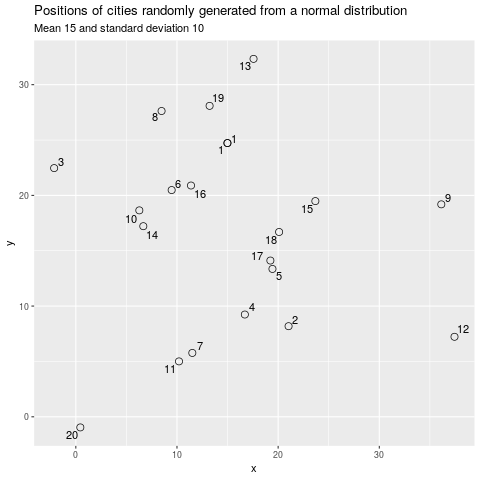

In [24]:
%%R
cities_rand%>%
  add_row(cities_rand[1,])%>%
  mutate(initial_pos=factor(c(seq(1,m),1)))%>%
  ggplot(aes(x,y, label = initial_pos))+
  geom_point(size=3,shape=1)+
  geom_text_repel()+
  labs(title = "Positions of cities randomly generated from a normal distribution",
       subtitle = "Mean 15 and standard deviation 10")

Let's also visualize the cities on the circle:

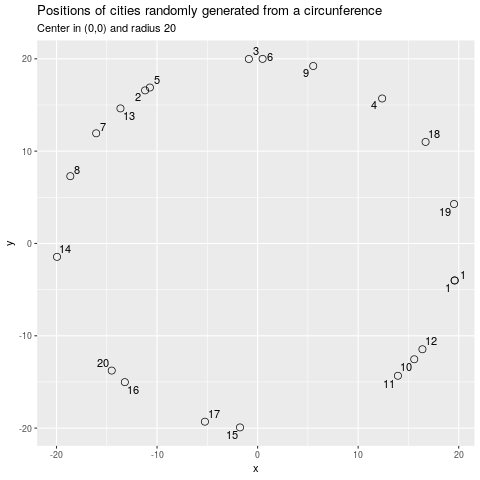

In [25]:
%%R
  cities_circle%>%
  add_row(cities_circle[1,])%>%
  mutate(initial_pos=factor(c(seq(1,m),1)))%>%
  ggplot(aes(x,y, label = initial_pos))+
  geom_point(size=3,shape=1)+
  geom_text_repel()+
  labs(title = "Positions of cities randomly generated from a circunference",
       subtitle = "Center in (0,0) and radius 20")

The function is implemented as follows:

In [26]:
%%R
eucl_dist<-function(x1,y1,x2,y2){
  d<-sqrt(((x1-x2)^2)+((y1-y2)^2))
  return(d)
}

matr_dist<-function(x_vect,y_vect){
  n<-length(x_vect)
  if(n!=length(y_vect)){
    cat("Error input")
    return(0)
  }
  else{
    dist_matr<-matrix(0,nrow = n,ncol = n)
    for(i in 1:n){
      for(j in 1:n){
        d<-eucl_dist(x_vect[i],y_vect[i],x_vect[j],y_vect[j])
        dist_matr[i,j]=dist_matr[j,i]=d
      }
    }
  }
  return(dist_matr)
}

eval_state<-function(sequence_inp,data){
  n<-length(sequence_inp)-1
  total_cost<-0
  for(i in 1:n){
    total_cost<-total_cost + data[sequence_inp[i],sequence_inp[i+1]]
  }
  return(total_cost)
}

sim_ann<-function(data_coord,cost_matr,dist="coordinate",cooling_func="log",
                  stop_crit=1000, max_iter=10000000){
  if(dist=="coordinate"){
    x<-data_coord[,1]
    y<-data_coord[,2]
    matr_cost<-matr_dist(x,y)
  }
  else if(dist=="matrix"){matr_cost<-cost_matr}
  n<-dim(matr_cost)[1]
  if(dim(matr_cost)[2]!=n){
    cat("Error input")
    return(0)
  }
  if(cooling_func=="log"){
    cost<-function(k){return(1/log(1+k))}
  }
  else if(cooling_func=="sqrt"){
    cost<-function(k){return(1/sqrt(1+k))}
  }
  init_path<-c(1,sample(c(2:n),size = n-1),1)
  new_path=old_path=init_path
  stop_iter<-0
  nr_iter<-1
  while(stop_iter<stop_crit & nr_iter<max_iter){
    old_value<-eval_state(old_path,matr_cost)
    # permutation + value
    swap<-sample(c(2:n),size = 2)
    new_path[swap[2]]<-old_path[swap[1]]
    new_path[swap[1]]<-old_path[swap[2]]
    new_value<-eval_state(new_path,matr_cost)
    if(new_value<old_value){
      old_path<-new_path
      stop_iter<-0
    }
    else{
      prob_succ<-exp(-(new_value-old_value)/cost(nr_iter))
      c_toss<-sample(c(0,1),size = 1,prob = c(1-prob_succ,prob_succ))
      if(c_toss>0){
        old_path<-new_path
        stop_iter<-0
      }
      else{
        new_path<-old_path
        stop_iter<-stop_iter+1
      }
    }
    nr_iter<-nr_iter+1
  }
  if(nr_iter==max_iter){cat("Reached maximum number of iterations",sep = "\n")}
  else if(stop_iter==stop_crit){cat("Reached stopping criteria",sep = "\n")}
  return(list("Path"=old_path,
              "Final cost"=eval_state(old_path,matr_cost),
              "Number Iteration"=nr_iter))
}

The function take as input both a matrix of distances between stations or a dataframe with x-y coordinate of the different stations, in this last case a matrix of distance (using the Euclidean Distance) is created, so the algorithm always work with a distance matrix (so a _symmetric_ matrix).

At every interation a new permutation(swap of 2 stations) is performed and the candidate state $Y$ is accepted if  the cost is less than the previous state or it is accepted with probability $\exp\left(-\left(U\left(Y_{i}\right)-U\left(X_{i}\right)\right) / T_{i}\right)$, where $U()$ evaluate the total distance covered for the specific state(path) and $T_{i}$ can be both $T_{i}=1 / \sqrt{1+i}$ or $T_{i}=-\log (i+1)$, where $i$ keeps track of the interaction, in case that the cost is not less.

There is a maximum number of iteration and a stop criteria if the candidate is rejected multiple times in a row (500 by default).

Let's compute the path for the random generated city and plot the result:

In [27]:
%%R
final_path_rand<-sim_ann(cities_rand)
final_path_rand

Reached stopping criteria
$Path
 [1]  1 15 18  5  2 20 11  7  4 17 16  6  8  3 10 14 12  9 13 19  1

$`Final cost`
[1] 189.7741

$`Number Iteration`
[1] 4034



The first plot will contain the simple path that goes from station 1 to n sequentially and then return to station 1, the indexes are according to the order of generation, The second plot will be the path computed with the simulation:

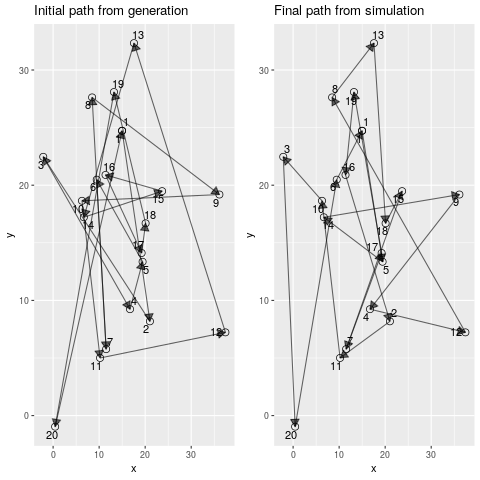

In [28]:
%%R
first<-cities_rand%>%
  add_row(cities_rand[1,])%>%
  mutate(initial_pos=factor(c(seq(1,m),1)))%>%
  ggplot(aes(x,y, label = initial_pos))+
  geom_point(size=3,shape=1)+
  geom_segment(aes(xend=c(tail(x, n=-1), NA), yend=c(tail(y, n=-1), NA)),
               arrow=arrow(length=unit(0.3,"cm"),type = "closed"),alpha=0.6)+
  geom_text_repel()+
    ggtitle("Initial path from generation")

df1<-cities_rand%>%
  mutate(initial_pos=factor(seq(1,m)))%>%
  mutate(final_pos=factor(final_path_rand$Path[1:m]))%>%
  arrange(final_pos)


second<-df1%>%
  add_row(df1[1,])%>%
  ggplot(aes(x,y, label = initial_pos))+
  geom_point(size=3,shape=1)+
  geom_segment(aes(xend=c(tail(x, n=-1), NA), yend=c(tail(y, n=-1), NA)),
               arrow=arrow(length=unit(0.3,"cm"),type = "closed"),alpha=0.6)+
  geom_text_repel()+
  ggtitle("Final path from simulation")

multiplot(first,second,cols = 2)

Finally the same for the cities in a circumference:

In [29]:
%%R
final_path_circle<-sim_ann(cities_circle)
final_path_circle

Reached stopping criteria
$Path
 [1]  1  8 14 20 16  6  9  4 18 17 15 11 10 12  7 13  2  5  3 19  1

$`Final cost`
[1] 273.8124

$`Number Iteration`
[1] 1233



And now the plots also for this:


It is also possible to experiment with the cooling function as $1 / \sqrt{1+i}$:

In [30]:
%%R
sim_ann(cities_circle,cooling_func = "sqrt")

Reached stopping criteria
$Path
 [1]  1 19 12 10 11 16 20 14  4 18 15 17  8  7 13  2  5  3  6  9  1

$`Final cost`
[1] 239.4038

$`Number Iteration`
[1] 2141




## Variance Reduction Method

The goal in this exercise is to use different technique that are used to reduce the variance of the estimator for simulated process.

This techniques exploit the relationship of the generated distribution in order to assure the aforementioned varianve reduction.

First, some definitions: the _Expected Value_ of a Random Variable is
$$
\operatorname{E}\left(g(x)\right) =\int g(x)f(x)dx
$$
Now taking in consideration the integral $\int_{0}^{1} e^{x} d x=\int_{0}^{1} e^{x} \cdot 1 \cdot dx$, with $\int_{0}^{1} 1 dx$  as the integral of the Uniform Distribution $U$.

Combining the two:
$$
\int_{0}^{x} e^{x}dx=E\left(e^{U}\right)
$$

So, it is possible to evaluate an integral computing the expected value.

There is a built-in function, let's see it result first:

In [31]:
%%R
eval_int<-function(x){exp(x)}
integrate(eval_int,0,1)

1.718282 with absolute error < 1.9e-14


As expected the variance is extremly low and the result is precisily the analytical one:

$$
\begin{aligned}
\int_{0}^{1} e^{x}dx&=e^1-e^0\\
&=2.7182818284-1\\
&=1.7182818284\\
\end{aligned}
$$

### Estimation of the integral $\int_{0}^{1} e^{x} d x$ by simulation (the crude Monte Carlo estimator). Use eg. an estimator based on 100 samples and present the result as the point estimator and a confidence interval.

The _crude Monte Carlo estimator_ can be used to evaluate the integral and is in the following form:

$$
X_{i}=e^{U_{i}} \qquad \bar{X}=\frac{\sum_{i=1}^{n} X_{i}}{n}
$$
In other words the integral is evaluated sampling the random variable $e^{U}$ and then computing the average.

In [32]:
%%R
eval_crude_MT<-function(n){
  u<-runif(n)
  res<-exp(u)
  return(list("Evaluation"=mean(res),"Variance"=var(res)))
}

crude_MT<-eval_crude_MT(1000)
crude_MT

$Evaluation
[1] 1.70004

$Variance
[1] 0.2437494



The variance of the estimator is large and the result is possibly quite distant from the analytical result (it depends on the random run as the seed is not setted), the variance should be $\sim 0.25$.

###  Estimation of the integral $\int_{0}^{1} e^{x} d x$ using antithetic variables, with comparable computer resources.

This is the a variance reduction technique that exploit the use of _Antithetic Variables_:

Considering a generated sequence of pseudo-number $X$, that is a function of $k$ random numbers:
$$
X=h\left(U_{1}, U_{2}, \ldots, U_{k}\right)
$$

Where $U=U_{1}, \ldots, U_{k}$ is uniformly distributed on $(0,1)$; 

$1-U$ is uniformly distributed on $(0,1)$ and negatively correlated with $U$, so a generated sequence $Y$:
$$
Y=h\left(1-U_{1}, 1-U_{2}, \ldots, 1-U_{k}\right)
$$
should have the same distribution as $X$ and also is negatively correlated with $X$ if $h$ is a _monotone_ function(as $e^x$).

Suppose the two distribution are compounded in a new random variable $Z=\frac{X+Y}{2}$, then the variance of $Z$ present a term of $2\operatorname{Cov}(X,Y)$, if this value is negative, then the variance is reduced.

The implementation to estimate the integral is:

In [33]:
%%R
eval_ant_var<-function(n){
  u<-runif(n)
  res<-0.5*(exp(u)+exp(1-u))
  return(list("Evaluation"=mean(res),"Variance"=var(res)))
}

ant_var<-eval_ant_var(500)
ant_var

$Evaluation
[1] 1.717366

$Variance
[1] 0.003638769



The choiche of $n=500$ is to use a total of 1000 samples as in the _crude Monte Carlo_ estimation.

The _relative_ variance reduction is:

In [34]:
%%R
1-(ant_var$Variance/crude_MT$Variance)

[1] 0.9850717


###  Estimation of the integral $\int_{0}^{1} e^{x} d x$ using a control variable, with comparable computer resources.

Suppose that:

- $E[X]$ is the estimator, where $X$ is the output of a simulation
- $Y$ is an output variable and its expected value is known $E[Y]=\mu_{y}$

For any constant $c$ the quantity
$$
X+c\left(Y-\mu_{y}\right)
$$
is an unbiased estimator of $E[X]$.

The constant $c$ can be choose to minimize the Variance setting:
$$
c=-\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(Y)}
$$
where the constant $c$ has opposite sign with respect to the covariance.

If quantities $\operatorname{Cov}(X, Y)$ and $\operatorname{Var}(Y)$ are not known, the sample estimate can be used.

$Y$ in this case is called _control variate_ for the simulation estimator $X$.

For the integral evaluation the _control variate_ can be directly $U$ with know mean $\mu_{U}=\frac{1}{2}$, and the implementation is:

In [35]:
%%R
eval_contr_var<-function(n){
  u<-runif(n)
  c<- -(cov(exp(u),u))/var(u)
  res<-exp(u)+c*(u-0.5)
  return(list("Evaluation"=mean(res),"Variance"=var(res)))
}

contr_var<-eval_contr_var(500)
contr_var

$Evaluation
[1] 1.714622

$Variance
[1] 0.003849372



The _relative_ variance reduction is:

In [36]:
%%R
1-(contr_var$Variance/crude_MT$Variance)

[1] 0.9842077


###  Estimation of the integral $\int_{0}^{1} e^{x} d x$ using stratified sampling, with comparable computer ressources.

This variance reduction technique called _stratified sampling_, as the name suggest utilize a resampling technique, and the result is that the variance is reduced because conditioned to the probability distribution of the _strata_(intervals) of the "original" estimator.

The function is created specifically to evaluate the proposed integral, following the formulation for $k=10$:
$$
W_{i}=\frac{e^{\frac{U_{i, 1}}{k}}+e^{\frac{1}{k}+\frac{U_{i, 2}}{k}}+\cdots+e^{\frac{9}{k}+\frac{U_{i, k}}{k}}}{k}
$$
In this case the probability distribution is uniform and constant over the intervals with a value $1/k$

The function iimplemented is as follows:

In [37]:
%%R
eval_straf_sampl<-function(n,k){
  if(n%%k!=0){
    return("Error choiche parameters")
  }
  else{
    size<-floor(n/k)
    res<-rep(0,size)
    for (i in 1:size){
      inter_res<-rep(0,k)
      for (j in 1:k){
        inter_res[j]<-((j-1)/k)+runif(1)/k
      }
      res[i]<-sum(exp(inter_res))/k
    }
  }
  return(list("Evaluation"=mean(res),"Variance"=var(res)))
}


straf_sampl<-eval_straf_sampl(100,10)
straf_sampl

$Evaluation
[1] 1.718028

$Variance
[1] 0.0001420605



This is the smallest variance registered for all the variance reduction techniques.

It can be interesting evaluate again using a single interval:

In [38]:
%%R
eval_straf_sampl(100,1)

$Evaluation
[1] 1.70573

$Variance
[1] 0.2655955



The result is equal to the _crude Monte Carlo estimator_

The _relative_ variance reduction for $k=10$ is:

In [39]:
%%R
1-(straf_sampl$Variance/crude_MT$Variance)

[1] 0.9994172


This is a very good result.

### Using of control variates to reduce the variance of the estimator dor the Discrete Event Simulation woth Poisson arrivals

Considering that both _arrival time_ and _service time_ are output of a simulation both with known mean, it should be possible to utilize one of them as control variate to reduce the variance of the estimator of the blocking fraction of customers;

Recall that the variance of an eponential distribution is:
$$
\operatorname{Var}(X_{exp})=\frac{1}{\lambda^{2}}
$$
the estimated variance for the _arrival time_ should be $\sim 1$:

In [40]:
%%R
var(rexp(10000,1))

[1] 0.957109


instead the estimated variance for the _service time_ should be $\sim 64$

In [41]:
%%R
var(rexp(10000,1/8))

[1] 62.04988


So the _service time_ will be the _control variate_.

Considering the previous notation $X$ is the _fraction of blocked customer_ and $Y$ is the _service time_:
$$
\begin{aligned}
Z&=X+c\left(Y-\mu_{y}\right)\\
c&=-\frac{\operatorname{Cov}(X, Y)}{\operatorname{Var}(Y)}
\end{aligned}
$$
Let's partially rewrite the simulation function:

In [42]:
%%R
sim_ev_by_ev_contr_var<-function(n=10000,lambda=1, mean=8,nr_units=10,seed=NULL){
  set.seed(seed)
  t_arrival<-rexp(n,lambda)
  t_service<-rexp(n,rate = 1/mean)
  event_list<-cumsum(t_arrival)
  t_free<-rep(0,nr_units)
  nr_served<-rep(0,nr_units)
  nr_rejected<-rep(0,nr_units)
  
  for (i in 1:length(event_list)){
    nr_free<-sum(event_list[i]>t_free)
    
    if(nr_free>0){
      ind<-which(event_list[i]>t_free)[sample(1:length(which(event_list[i]>t_free)),1)]
      t_free[ind]<-event_list[i]+t_service[i]
      nr_served[ind]<- nr_served[ind]+1
      nr_rejected[i]<-0
    }
    
    else{
      nr_rejected[i]<-1
    }
  }
    return(c(sum(nr_rejected)/n,mean(t_service)))
}

The function return two estimates, the _blocking fraction_ and the mean of the _service time_

Now a matrix whose rows are the output of 10 runs and the columns are _blocking fraction_ and _service time_

In [43]:
%%R
s<-8
x<-matrix(replicate(10,sim_ev_by_ev_contr_var()),ncol=2,byrow = TRUE)
c<- - cov(x[,1],x[,2])/var(x[,2])
y<-x[,1]+c*(x[,2]-s)

In [44]:
%%R
cat("The Mean values for the estimator WITHOUT using the control variate is:",
    sep = "\n")
apply(x,2,mean)[1]

The Mean values for the estimator WITHOUT using the control variate is:
[1] 0.12521


In [45]:
%%R
cat("The Variance for the estimator WITHOUT using the control variate (10 runs) is:",
    sep = "\n")
apply(x,2,var)[1]

The Variance for the estimator WITHOUT using the control variate (10 runs) is:
[1] 3.332767e-05


In [46]:
%%R
cat("The Mean values for the estimator WITH the use of control variate is:",
    sep = "\n")
mean(y)

The Mean values for the estimator WITH the use of control variate is:
[1] 0.1249741


In [47]:
%%R
cat("The Variance for the estimator WITH the use of control variate (10 runs) is:",
    sep = "\n")
var(y)

The Variance for the estimator WITH the use of control variate (10 runs) is:
[1] 3.31533e-05


We can see the result printed below(using the functions "apply()", "mean()" and "var()":



The variance for the runs with the use of _control variate_ is extremely low $\sim 0$, but there is not a _significant_ reduction in absolute term, in relative one it should be around a factor of 2(no reproducibile result here).

Possibly the reason is that the correlation between the sequence of rejected customer and the _service time_ is not strongly correlated. The same result happens using _arrival time_; considering the literature, this method is well suited for an estimation of the _time delay_, something that is not in our interest.

In any case the result is in general term already satisfactory (difficult to improve) and the variance is extremely low.

### Use of common random numbers for the difference between Poisson arrivals and a renewal process with hyperexponential interarrival times

The technique that involves the use of _Common numbers_ can be useful to compare 2 estimators, as in this case the inter-arrival times are generated from the same _common_ uniform distribution;

For the _hyperexponential distribution_ will be used the inverse transform method, solving a nonlinear equation, the CDF is:
$$
F_X(x)=p_1 \cdot (1- e^{-\lambda_1 \ x})+p_2 \cdot (1- e^{-\lambda_2 \ x})+\cdots+p_m \cdot (1- e^{-\lambda_m \ x})
$$
In our case with $m=2$:
$$
F_X(x)=1- (p_1 \cdot e^{-\lambda_1 \ x}+p_2 \cdot e^{-\lambda_2 \ x})
$$
And setting $F_X=u$:

In [48]:
%%R
cdf_hyper<-function(x,u,lambda1=0.8333,lambda2=5.0,p1=0.8,p2=0.2){
  eq<-(1-p1*exp(-lambda1*x)+p2*exp(-lambda2*x))-u
  return(eq)
}

The implementation of the simulation is as follows:

In [49]:
%%R
## common number poisson
poisson_common_number<-function(unif,lambda){
  times<- -log(unif)*(1/lambda)
  return(cumsum(times))
}


## common number hyperexp
hyperexp_common_number<-function(unif){
  n<-length(unif)
  times<-rep(0,n)
  for(i in 1:n){t
    times[i]<-nleqslv(x = 1, fn = cdf_hyper,u=unif[i])$x
  }
  return(cumsum(times))
}

## simulation
sim_ev_by_ev_common_number<-function(event_list, t_service=8,nr_units=10){
  t_free<-rep(0,nr_units)
  nr_served<-rep(0,nr_units)
  nr_rejected<-0
  for (t_clock in event_list){
    nr_free<-sum(t_clock>t_free)
    
    if(nr_free>0){
      ind<-which(t_clock>t_free)[sample(1:length(which(t_clock>t_free)),1)]
      t_free[ind]<-t_clock+t_service
      nr_served[ind]<- nr_served[ind]+1
    }
    
    else{
      nr_rejected<-nr_rejected+1
    }
  }

  return(nr_rejected/(sum(nr_served)+nr_rejected))
}

It should be noted that to facilitate the comparison the service time is constant with $s=8$.

So now it is possible to proceed with the comparison of the 2 estimators

In [50]:
%%R
poisson_same<-rep(0,10)
hyper_same<-rep(0,10)
hyper_diff<-rep(0,10)
for(i in 1:10){
  set.seed(i)
  u1<-runif(1000)
  set.seed(i*100+15)
  u2<-runif(1000)
  set.seed(NULL)
  event_poi_same<- poisson_common_number(unif = u1,lambda = 1)
  
  event_hyper_same<- hyperexp_common_number(unif=u1)
  
  event_hyper_diff<-hyperexp_common_number(unif=u2)
  
  poisson_same[i]<-sim_ev_by_ev_common_number(event_poi_same)
  hyper_same[i]<-sim_ev_by_ev_common_number(event_hyper_same)
  hyper_diff[i]<-sim_ev_by_ev_common_number(event_hyper_diff)
}

Our interest is to compute the difference between the 2 estimators, so let name this difference as _difference estimator_:

In [51]:
%%R
x_same<-poisson_same-hyper_same
x_diff<-poisson_same-hyper_diff

In [52]:
%%R
cat("","The mean of the difference estimator with 10 runs and  WITH common numbers is:",sep = "\n")
mean(x_same)


The mean of the difference estimator with 10 runs and  WITH common numbers is:
[1] -0.056


In [53]:
%%R
cat("","The variance of the difference estimator with 10 runs and WITH common numbers is:",sep = "\n")
var(x_same)


The variance of the difference estimator with 10 runs and WITH common numbers is:
[1] 0.0004833333


In [54]:
%%R
cat("","The mean of the difference estimator with 10 runs and  WITHOUT common numbers is:",sep = "\n")
mean(x_diff)


The mean of the difference estimator with 10 runs and  WITHOUT common numbers is:
[1] -0.0593


In [55]:
%%R
cat("","The variance of the difference estimator with 10 runs and WITHOUT common numbers is:",sep = "\n")
var(x_diff)


The variance of the difference estimator with 10 runs and WITHOUT common numbers is:
[1] 0.0007822333


As possible to see the variance is minimal but there is not a _significat_ improvement in general term, in relative term there is a variance reduction around a factor of 2.